In [9]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Fri December 06 18:08 UTC 2024
# Version:        1.0
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth on a Raspberry Pi 5 with a standard USB camera. An image with a 
resolution of 640px x 480px can be recorded with the Python script 
create-symbols-dataset.py.
The files in the dataset <2023 symbols> should be ordered in the following
manner:             > explanation
- 2023 symbols      
  - dataset3        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt

# Enable Nvidia GPUs by un-commenting this line 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"

# To get reproducable results with the same training setting random seed
SEED = 42
np.random.seed(SEED)

# Flags
plots_on = True
test_on_specific_image = False

In [10]:
# =============================================================================
# Define functions
# =============================================================================
# Change image size and convert to grayscale images
def pic_prep (image, x, y):
  image = cv2.resize(image, (y,x)) # change image size
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  image = image / 255 # image normalization
  return image

# Shuffle images
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# todo: only show output of training for every 10 epochs
# Add callback to only print loss etc. after e.g. 10 epochs:
# https://stackoverflow.com/questions/44931689/how-to-disable-printing-reports-after-each-epoch-in-keras
class callback_print(callbacks.Callback):
    SHOW_NUMBER = 10
    counter = 0
    epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        if self.counter == self.SHOW_NUMBER or self.epoch == 1:
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
            if self.epoch > 1:
                self.counter = 0
        self.counter += 1

In [11]:
# =============================================================================
# Function with some hypterparameters to change for comparison
# =============================================================================
def train_symbols_model(num_training=0,
                        image_size=[32, 28], #
                        num_neurons_per_layer=[64,32,16,4],
                        batch_size=4,
                        epochs=300):
    # =============================================================================
    # Declare variables
    # =============================================================================
    img_size_x = image_size[0]
    img_size_y = image_size[1]
    img_dim = img_size_x * img_size_y

    # Change the following paths to your dataset path
    home_dir = os.path.expanduser("~")
    img_dir = home_dir + "/ml_project/datasets/symbols/dataset1/data"
    gt_dir = home_dir + "/ml_project/datasets/symbols/dataset1/gt"
    checkpoint_filepath = home_dir + "/ml_project/datasets/symbols/dataset1/chpt/"

    # =============================================================================
    # Get number of data (image/label) 
    # =============================================================================
    anz_data = len(os.listdir(img_dir))
    anz_data = int(anz_data) - 1
    dataset = np.zeros((anz_data, img_size_x, img_size_y), dtype=float)
    ground_truth = np.zeros((anz_data), dtype=int)
    #print("dataset size:", anz_data)

    # =============================================================================
    # Callback for training
    # =============================================================================
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath + str(num_training) + "-chpt.model.keras",
        save_weights_only=False,
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True,
        verbose = 1)
    
    # =============================================================================
    # Read dataset
    # =============================================================================
    for i in range(0, anz_data, 1):
        img_name = img_dir + '/' + str(i) + '.png'      # create file names
        image = cv2.imread(img_name)                    # read image
        image = pic_prep(image, img_size_x, img_size_y) # prepare image
        dataset[i,:,:] = image                          # 2d-image to 3d-array
        
        txt_name = gt_dir + '/' + str(i) + '.txt'       # create gt file names
        ground_truth[i] = np.genfromtxt(txt_name, delimiter=',') 

    # =============================================================================
    # Prepare dataset: train set (80%) and test set (20%)
    # =============================================================================
    dataset = dataset.reshape(anz_data, img_dim) # convert into 2d array (all pixel in one row)
    ground_truth = ground_truth.reshape(anz_data, 1)

    dataset, ground_truth = unison_shuffle(dataset, ground_truth)

    trainset = np.random.choice(dataset.shape[0],
                                int(dataset.shape[0]*0.80), 
                                replace=False)
    train_data = dataset[trainset,:]
    train_gt = ground_truth[trainset]
    train_gt = utils.to_categorical(train_gt, 4)

    testset = np.delete(np.arange(0, len(ground_truth) ), 
                        trainset) 
    test_data = dataset[testset,:]
    test_gt = ground_truth[testset]
    test_gt = utils.to_categorical(test_gt, 4)
    #print(ground_truth)
    #print(dataset)
    #print(trainset)
    #print(train_data)
    #print(train_gt)

    # =============================================================================
    # Create neural network with e.g. 4 layers and (64, 32, 16, 4) neurons per layer.
    # =============================================================================
    model = models.Sequential()
    model.add(layers.Dense(num_neurons_per_layer[0], input_dim=img_dim,activation='relu'))
    model.add(layers.Dense(num_neurons_per_layer[1], activation='relu'))
    model.add(layers.Dense(num_neurons_per_layer[2], activation='relu'))
    model.add(layers.Dense(num_neurons_per_layer[3], activation='sigmoid'))
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    # =============================================================================
    # Train the neuronal network e.g. for e.g. 300 epochs.
    # =============================================================================
    history = model.fit(train_data, 
                        train_gt, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=0, 
                        shuffle=True, 
                        validation_data=(test_data, test_gt), 
                        callbacks=[model_checkpoint_callback])
    
    # =============================================================================
    # Plot train and val accuracy.
    # =============================================================================
    if plots_on:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        # =========================================================================
        # Plot train and val loss.
        # =========================================================================
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower left')
        plt.show()
    
    if test_on_specific_image:
        # =========================================================================
        # Load pretrained dataset weights to e.g. test on new (unseen) data.
        # =========================================================================
        model.load_weights(checkpoint_filepath + ".keras")   

        # =========================================================================
        # Test dataset on xxx.
        # =========================================================================
        score = model.evaluate(test_data, test_gt, verbose=1)
        print('Test score:', score[0])
        print('Test accuracy:', score[1])       

        # =========================================================================
        # Testing on a single image.
        # =========================================================================
        data_pred = np.zeros((1, img_size_x, img_size_y), dtype=float)
        img_pred = cv2.imread(home_dir + "/ml_project/datasets/symbols/dataset1/data/13.png")
        img_pred = pic_prep(img_pred, img_size_x, img_size_y)
        data_pred[0,:,:] = img_pred
        data_pred = data_pred.reshape(1,img_dim)
        result = model.predict(data_pred)
        result = np.round(result, decimals=2)
        print("Probability for class (cross, circle, triangle, square) in percent", 
            result)
        
        # =============================================================================
        # Output class: 
        # translate class label (0,1,2,3) to class (cross, circle, triangle, square).
        # =============================================================================
        max_res = 0
        res_index = 4
        for i in range(0, 4, 1):
            if result[0,i] > max_res:
                max_res = result[0,i]
                res_index = i

        if res_index == 0:
            print('Cross detected!')
        elif res_index == 1:
            print('Circle detected!')
        elif res_index == 2:
            print('Triangle detected!')
        elif res_index == 3:
            print('Square detected!')
        elif res_index == 4:
            print('Error!')

Training 1 with image size [32, 28] and [256, 32, 16, 4] neurons per layer


/home/metzgeka/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-11 11:39:50.908859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-11 11:39:50.908879: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: fos-deeplearning
2025-01-11 11:39:50.908882: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: fos-deeplearning
2025-01-11 11:39:50.908948: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.127.8
2025-01-11 11:39:50.908959: I external/local_xla/xl


Epoch 1: val_accuracy improved from -inf to 0.22857, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/1-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.22857

Epoch 3: val_accuracy did not improve from 0.22857

Epoch 4: val_accuracy did not improve from 0.22857

Epoch 5: val_accuracy did not improve from 0.22857

Epoch 6: val_accuracy improved from 0.22857 to 0.25714, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/1-chpt.model.keras

Epoch 7: val_accuracy did not improve from 0.25714

Epoch 8: val_accuracy did not improve from 0.25714

Epoch 9: val_accuracy did not improve from 0.25714

Epoch 10: val_accuracy improved from 0.25714 to 0.31429, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/1-chpt.model.keras

Epoch 11: val_accuracy did not improve from 0.31429

Epoch 12: val_accuracy did not improve from 0.31429

Epoch 13: val_accuracy did not improve from 0.31429

Epoch 14: val_accuracy did not 

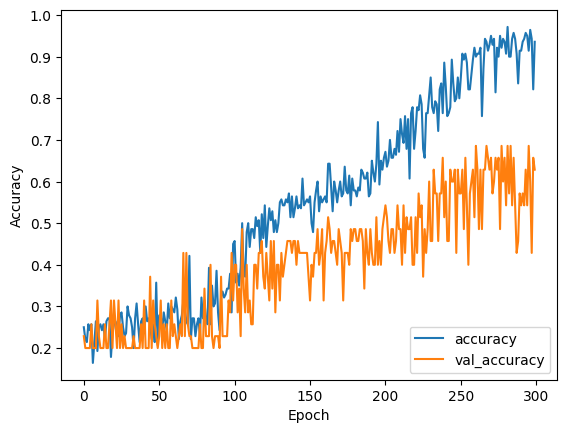

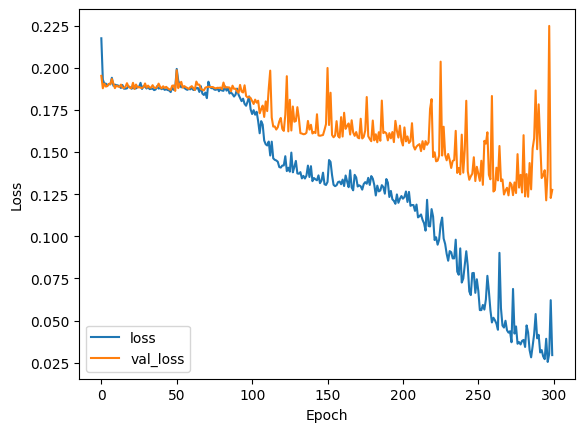

#################################################

Training 2 with image size [32, 28] and [128, 32, 16, 4] neurons per layer

Epoch 1: val_accuracy improved from -inf to 0.25714, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/2-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.25714

Epoch 3: val_accuracy did not improve from 0.25714

Epoch 4: val_accuracy did not improve from 0.25714

Epoch 5: val_accuracy did not improve from 0.25714

Epoch 6: val_accuracy improved from 0.25714 to 0.34286, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/2-chpt.model.keras

Epoch 7: val_accuracy did not improve from 0.34286

Epoch 8: val_accuracy did not improve from 0.34286

Epoch 9: val_accuracy did not improve from 0.34286

Epoch 10: val_accuracy did not improve from 0.34286

Epoch 11: val_accuracy did not improve from 0.34286

Epoch 12: val_accuracy did not improve from 0.34286

Epoch 13: val_accuracy did not improve from 0.34286

Ep

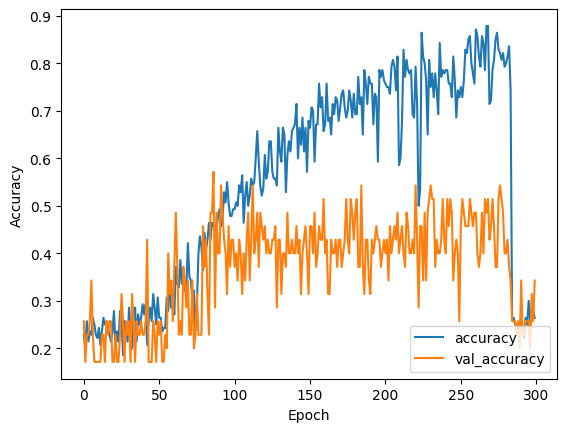

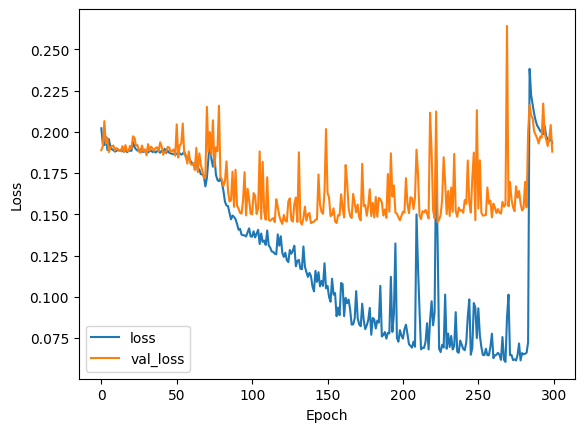

#################################################

Training 3 with image size [32, 28] and [64, 32, 16, 4] neurons per layer

Epoch 1: val_accuracy improved from -inf to 0.31429, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/3-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.31429

Epoch 3: val_accuracy did not improve from 0.31429

Epoch 4: val_accuracy did not improve from 0.31429

Epoch 5: val_accuracy did not improve from 0.31429

Epoch 6: val_accuracy did not improve from 0.31429

Epoch 7: val_accuracy did not improve from 0.31429

Epoch 8: val_accuracy did not improve from 0.31429

Epoch 9: val_accuracy did not improve from 0.31429

Epoch 10: val_accuracy did not improve from 0.31429

Epoch 11: val_accuracy did not improve from 0.31429

Epoch 12: val_accuracy improved from 0.31429 to 0.34286, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/3-chpt.model.keras

Epoch 13: val_accuracy did not improve from 0.34286

Epo

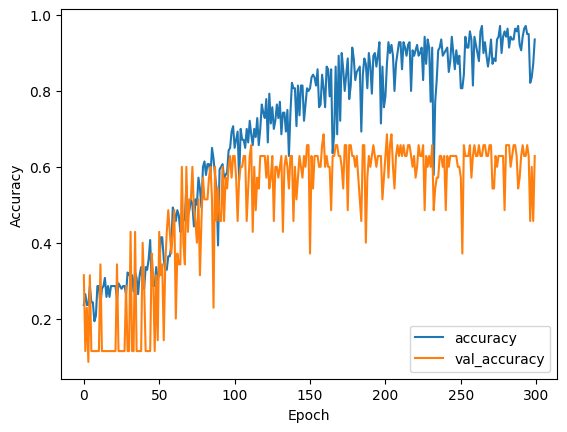

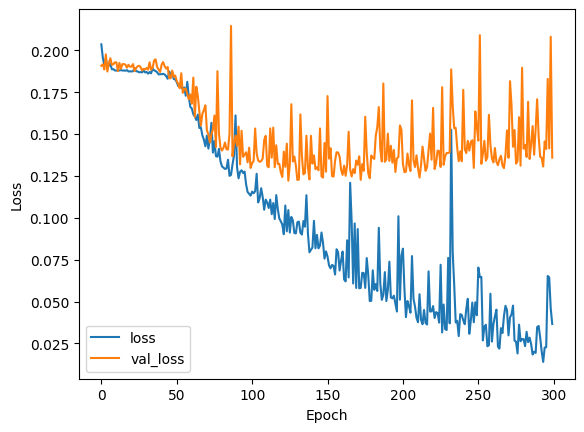

#################################################

Training 4 with image size [32, 28] and [32, 32, 16, 4] neurons per layer

Epoch 1: val_accuracy improved from -inf to 0.22857, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/4-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.22857

Epoch 3: val_accuracy did not improve from 0.22857

Epoch 4: val_accuracy did not improve from 0.22857

Epoch 5: val_accuracy did not improve from 0.22857

Epoch 6: val_accuracy did not improve from 0.22857

Epoch 7: val_accuracy did not improve from 0.22857

Epoch 8: val_accuracy did not improve from 0.22857

Epoch 9: val_accuracy did not improve from 0.22857

Epoch 10: val_accuracy did not improve from 0.22857

Epoch 11: val_accuracy did not improve from 0.22857

Epoch 12: val_accuracy did not improve from 0.22857

Epoch 13: val_accuracy did not improve from 0.22857

Epoch 14: val_accuracy did not improve from 0.22857

Epoch 15: val_accuracy did not improve from 0.2

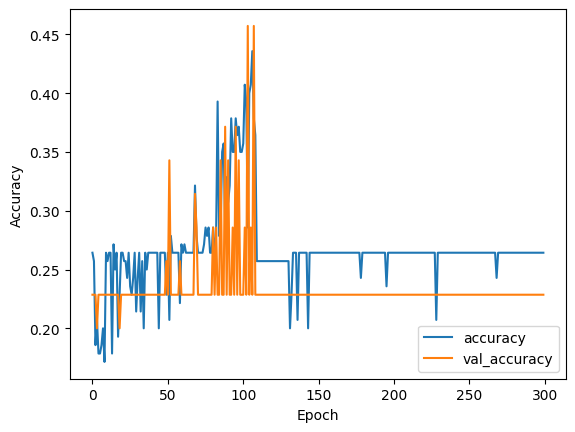

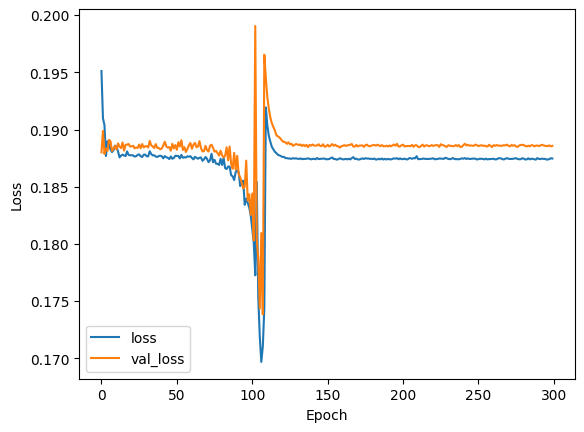

#################################################

Training 5 with image size [32, 28] and [16, 32, 16, 4] neurons per layer

Epoch 1: val_accuracy improved from -inf to 0.25714, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/5-chpt.model.keras

Epoch 2: val_accuracy did not improve from 0.25714

Epoch 3: val_accuracy did not improve from 0.25714

Epoch 4: val_accuracy did not improve from 0.25714

Epoch 5: val_accuracy improved from 0.25714 to 0.28571, saving model to /home/metzgeka/ml_project/datasets/symbols/dataset1/chpt/5-chpt.model.keras

Epoch 6: val_accuracy did not improve from 0.28571

Epoch 7: val_accuracy did not improve from 0.28571

Epoch 8: val_accuracy did not improve from 0.28571

Epoch 9: val_accuracy did not improve from 0.28571

Epoch 10: val_accuracy did not improve from 0.28571

Epoch 11: val_accuracy did not improve from 0.28571

Epoch 12: val_accuracy did not improve from 0.28571

Epoch 13: val_accuracy did not improve from 0.28571

Epo

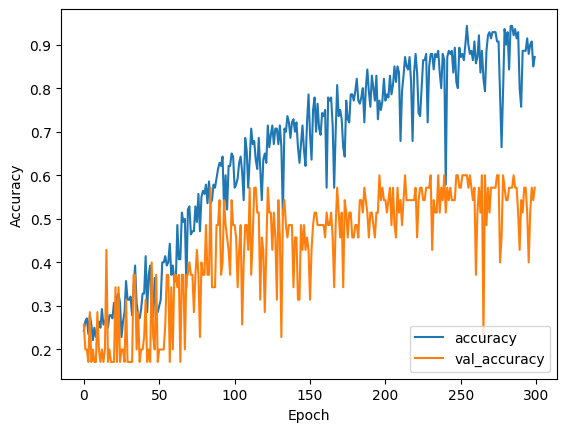

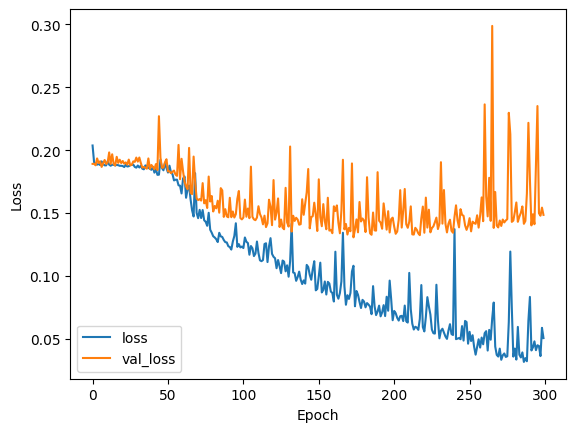

#################################################



In [12]:
# =============================================================================
# Train multiple networks with differend image scales and neurons per layer
# =============================================================================
"""
image_dims = [[32, 28],
              [32, 28],
              [32, 28]]
neurons_layers = [[64,32,16,4],
                  [32,32,16,4],
                  [16,32,16,4]]
"""
image_dims = [[32, 28],
              [32, 28],
              [32, 28],
              [32, 28],
              [32, 28]]
neurons_layers = [[256,32,16,4],
                  [128,32,16,4],
                  [64,32,16,4],
                  [32,32,16,4],
                  [16,32,16,4]]

# Train multiple times with different hyper parameters (dim img size, neurons per layer)
i = 1
for img_size, num_neurons in zip(image_dims, neurons_layers):
    print("Training", i, "with image size", img_size, "and", num_neurons, "neurons per layer")
    train_symbols_model(i, img_size, num_neurons, 4, 300)
    print("#################################################\n")
    i+=1